# Creación de base de datos para identificación de HVs

El presente archivo se creará la base de datos extrayendo información de HVs usando procesamiento de lenguaje natural. Esto con el objetivo de más adelante tener la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las características predominantes de una HV que hace que avance o no durante el proceso.



#### Importar librerias

In [1]:
import os
import fitz  # PyMuPDF for PDFs
import pytesseract
from PIL import Image
import pandas as pd
import re
import spacy
import io
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

### Importar SpaCy para NLP
Spacy es una librería de python que permite por medio de modelos de lenguaje pre-importados realizar análisis de texto, identificando palabras, nombres, lugares, objetos, verbos, adjetivos y la relación entre los mismos.

En este caso, importamos el modelo pre-entrenado en inglés, lo que requiere que todas las CVs a procesar estén en este idioma.


In [2]:
nlp = spacy.load("en_core_web_sm")

#### Cargar las carpetas con las HVs

In [3]:
hv_dir_exitosas_java = "hojas_de_vida/java/Paso"
hv_dir_noexitosas_java = "hojas_de_vida/java/No Paso"
hv_dir_exitosas_front = "hojas_de_vida/frontend/Paso"
hv_dir_noexitosas_front = "hojas_de_vida/frontend/No Paso"

### Deifinir palabras clave
En este caso, se definirar palabras clave que podrán tener las HVs teniendo en cuenta que para este modelo en particular se está utlizando solo HVs para un requerimiento de **desarrolladores Java**.


In [4]:
palabras_clave_java = ["Java", "Spring", "spring boot", "AWS", "Azure", "GCP", "Google Cloud Platform", "microservices", "Maven", "Gradle", "Java Server Pages", "JSP", "JEE", "Java Enterprise Edition", "Java8", "Java11", "Java17", "Java21", "JVM", "Java virtual machine"]

palabras_clave_front_end = ["Javascript", "Typescript", "React", "Angular", "Vue", "react.js", "vue.js", "HTML", "CSS", "Redux", "Hooks", "Micro frontends", "JS", "Node", "Node.js"]

### Definir las secciones y los patrones en las que estas van a aparecer
Además de definir la cantidad de palabras clave, es importante contar con las secciones con las que cada documento puede contar y entender si cuenta o no con este.

In [5]:
secciones = {
    "education": r"education|academic\s+background|studies|study|university\s+studies|professional\s+education",
    "work_experience": r"experience|work|work\s+experience|employment\s+history|professional\s+experience|background|professional\s+background",
    "skills": r"skills|technical\s+skills|competencies",
    "certifications": r"certifications|licenses|accreditations",
    "achievements": r"achievements|achieved",
    "professional_profile": r"profile|summary|about\s+me|professional\s+summary|objective|summary",
    "languages": r"languages|linguistic\s+skills|spoken\s+languages",
    "projects": r"projects|case\s+studies|portfolio",
    "publications": r"publications|research\s+papers|articles|books",
    "training_courses": r"training|courses|workshops|online\s+learning",
    "volunteer_work": r"\bvolunteer(?:ing)?(?:\s+work)?\b|community\s+service|social\s+impact|non-profit",
}

### Detectar el tipo de HV para posterior procesamiento de palabras clave


In [6]:
def detect_cv_type(cv_path):
    if "java" in cv_path.lower():
        return "java"
    elif "frontend" in cv_path.lower():
        return "frontend"
    else:
        return "unknown"  # Default case if it's unclear

### Extraer el texto de los PDFs

A continuación se usará la librería FITZ, la cual ayuda a extraer el texto de un PDF, ver si tiene imágenes, contar sus páginas y detectar colores en los mismos.

La declaramos como función para llamarla más adelante en el procesamiento de todas las características que buscamos extraer.

In [7]:
def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF, handling both text-based and image-based (scanned) content."""
    text = []
    try:
        doc = fitz.open(pdf_path)

        for page in doc:
            # Extract text from the page (use "blocks" for better structure)
            page_text = "\n".join(block[4] for block in page.get_text("blocks"))
            text.append(page_text)

            # Handle OCR for image-based text (scanned PDFs)
            for img_index, img in enumerate(page.get_images(full=True)):
                base_image = doc.extract_image(img[0])
                img_bytes = base_image["image"]

                # Convert image bytes to a PIL image
                img_pil = Image.open(io.BytesIO(img_bytes))

                # ✅ Fix: Convert RGBA or P-mode images (with transparency) to RGB
                if img_pil.mode in ("RGBA", "P"):
                    img_pil = img_pil.convert("RGB")

                # Convert image to text using OCR
                ocr_text = pytesseract.image_to_string(img_pil)
                text.append(ocr_text)

    except Exception as e:
        print(f"❌ Error extracting text from {pdf_path}: {e}")

    return "\n".join(text).strip()

### Contar palabras en general

In [8]:
def contar_palabras(text):
    return len(text.split()) if text else 0

#### Contar palabras clave

In [9]:
def contar_palabras_clave(text, cv_type):
    """
    Counts occurrences of keywords in the CV text using regex for better accuracy.
    - Handles variations like hyphens, spaces, and case differences.
    - Uses word boundaries `\b` but allows for slight variations in spacing.
    """
    text_lower = text.lower()

    # Choose the correct keyword list based on CV type
    keyword_list = palabras_clave_java if cv_type == "java" else palabras_clave_front_end

    count = 0
    for keyword in keyword_list:
        keyword_pattern = re.escape(keyword).replace(" ", r"\s*[-_]?\s*")  # ✅ Fix: Create regex separately
        keyword_regex = rf"\b{keyword_pattern}\b"  # ✅ Now safely formatted

        matches = re.findall(keyword_regex, text_lower, re.IGNORECASE)
        count += len(matches)  # Sum occurrences

    return count

#### Extraer las secciones

Para extraer las secciones, usamos expresiones regulares. Con la biblioteca Re, busca el patron definido en la variable secciones más arriba, que ayuda a identificar si el texto obtenido del PDF tiene o no esta sección.

In [10]:
def extraer_secciones(text):
    """Extracts sections with improved regex handling."""
    sections = {key: {"exists": False, "word_count": 0} for key in secciones.keys()}
    section_positions = {}

    for section, pattern in secciones.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            sections[section]["exists"] = True
            section_positions[section] = match.start()

    sorted_sections = sorted(section_positions.items(), key=lambda x: x[1])

    for i, (section, start_pos) in enumerate(sorted_sections):
        end_pos = sorted_sections[i + 1][1] if i + 1 < len(sorted_sections) else len(text)
        section_text = text[start_pos:end_pos].strip()
        sections[section]["word_count"] = contar_palabras(section_text) if section_text else 0

    return sections


### Nivel educativo

In [11]:
def extract_education_level(text):
    """Extracts the highest education level from the CV text."""
    education_levels = ["phd", "master", "bachelor", "associate", "diploma"]
    for level in education_levels:
        if re.search(r"\b" + level + r"\b", text, re.IGNORECASE):
            return level
    return "unknown"

### Idiomas

In [12]:
def extract_languages(text):
    """Extracts skills using SpaCy's entity recognition."""
    doc = nlp(text)
    skills = [ent.text for ent in doc.ents if ent.label_ in ["LANGUAGE"]]
    return list(set(skills))

### Job title
Verificar el título que usa el candidato para presentarse

In [13]:
def extract_job_titles(text):
    """Extracts the highest education level from the CV text."""
    titles = ["engineer", "developer", "analyst", "manager", "lead", "architect"]
    for title in titles:
        if re.search(r"\b" + title + r"\b", text, re.IGNORECASE):
            return title
    return "unknown"

### Verificar factores como foto y colores
De vuelta se usa la librería fitz para poder leer el PDF

#### Verificar si tiene o no foto

In [14]:
def tiene_foto_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        for page in doc:
            if len(page.get_images(full=True)) > 0:
                return True
    except Exception as e:
        print(f"Error revisando foto en PDF {pdf_path}: {e}")
    return False

#### Verificar si tiene colores adicionales el PDF

In [15]:
def tiene_color_pdf(pdf_path):
    """Detects if a PDF contains non-black/gray colors in drawings or images."""
    try:
        doc = fitz.open(pdf_path)

        for page in doc:
            # Check vector elements (lines, shapes)
            for draw in page.get_drawings():
                if "color" in draw and draw["color"] is not None:  # ✅ Check if "color" exists
                    r, g, b = draw["color"]
                    if (r, g, b) != (0, 0, 0) and r != g != b:  # Exclude black & grayscale
                        return True

            # Check images in the PDF
            for img_index, img in enumerate(page.get_images(full=True)):
                base_image = doc.extract_image(img[0])
                img_bytes = base_image["image"]

                # Convert image bytes to a PIL image
                img_pil = Image.open(io.BytesIO(img_bytes))

                # ✅ Fix: Convert RGBA images (with transparency) to RGB
                if img_pil.mode == "RGBA":
                    img_pil = img_pil.convert("RGB")

                # Convert image to a NumPy array
                img_np = np.array(img_pil)

                # Check if the image contains any non-grayscale pixels
                if len(img_np.shape) == 3:  # Ensure it's a color image
                    r, g, b = img_np[:, :, 0], img_np[:, :, 1], img_np[:, :, 2]
                    if np.any((r != g) | (g != b)):  # If any pixel has unequal R, G, B, it's colored
                        return True

    except Exception as e:
        print(f"❌ Error detecting color in PDF {pdf_path}: {e}")

    return False  # If no color found, return False

#### Contar páginas

In [16]:
def contar_paginas(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        return len(doc)
    except Exception as e:
        print(f"Error counting pages in PDF {pdf_path}: {e}")
        return 1

### Procesamiento del CV
A continuación la función de procesamiento, nos ayudará a procesar un solo CV de acuerdo a los parámetros establecidos anteriormente, ejecutando cada una de las funciones ya establecidas

In [17]:
def process_cv(cv_path):
    tipo_cv = detect_cv_type(cv_path)  # Added text
    text = extract_text_from_pdf(cv_path)
    if not text:
        print(f"⚠️ No text extracted from {cv_path}")
    has_photo = tiene_foto_pdf(cv_path)
    has_colors = tiene_color_pdf(cv_path)
    num_pages = contar_paginas(cv_path)
    total_word_count = contar_palabras(text)
    keyword_count = contar_palabras_clave(text, tipo_cv)
    sections = extraer_secciones(text)
    languages = extract_languages(text)
    education_level = extract_education_level(text)
    job_title = extract_job_titles(text)


    # Calculate keyword ratio
    keyword_ratio = keyword_count / total_word_count if total_word_count > 0 else 0

    return {
        "CV_Name": os.path.basename(cv_path),
        "Total_Word_Count": total_word_count,
        "Has_Photo": int(has_photo),
        "Has_Colors": int(has_colors),
        "Pages": num_pages,
        "Keyword_Count": keyword_count,
        "Keyword_Ratio": keyword_ratio,  # Added keyword ratio
        "Education_Exists": int(sections["education"]["exists"]),
        "Education_Word_Count": sections["education"]["word_count"],
        "Work_Experience_Exists": int(sections["work_experience"]["exists"]),
        "Work_Experience_Word_Count": sections["work_experience"]["word_count"],
        "Skills_Exists": int(sections["skills"]["exists"]),
        "Skills_Word_Count": sections["skills"]["word_count"],
        "Certifications_Exists": int(sections["certifications"]["exists"]),
        "Certifications_Word_Count": sections["certifications"]["word_count"],
        "Achievements_Exists": int(sections["achievements"]["exists"]),
        "Achievements_Word_Count": sections["achievements"]["word_count"],
        "Professional_Profile_Exists": int(sections["professional_profile"]["exists"]),
        "Professional_Profile_Word_Count": sections["professional_profile"]["word_count"],
        "Projects_Exists": int(sections["projects"]["exists"]),
        "projects_Word_Count": sections["projects"]["word_count"],
        "volunteer_work_Exists": int(sections["volunteer_work"]["exists"]),
        "volunteer_work_Word_Count": sections["volunteer_work"]["word_count"],
        "Education_Level": education_level,
        "Job_Title": job_title,
        "Languages": languages,
    }

### Procesamiento de CVs en la carpeta
La siguiente función nos ayuda a de acuerdo con lo establecido anteriormente, procesar todas las CVs en las carpetas seleccionadas y devolverlas en una lista

In [18]:
def process_folder(folder_path, label):
    cv_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            cv_path = os.path.join(folder_path, filename)
            print(f"Processing: {cv_path}")
            cv_info = process_cv(cv_path)
            cv_info["Passed"] = label
            cv_data.append(cv_info)
    return cv_data

## Creación de la base de datos

Se crean las variables donde se almacenan las CVs exitosas procesadas, agregando la información de 1 si es exitosa y 0 si no es exitosa.

In [96]:
# 📌 Process All CVs & Create Dataset
data_total = (process_folder(hv_dir_exitosas_java, 1) +
              process_folder(hv_dir_noexitosas_java, 0) +
              process_folder(hv_dir_exitosas_front, 1) +
              process_folder(hv_dir_noexitosas_front, 0))

Processing: hojas_de_vida/java/Paso\11686212-CV-Jorge Vidal.pdf
Processing: hojas_de_vida/java/Paso\14483303-Andres_Gomez_resume.docx (2) (1).pdf
Processing: hojas_de_vida/java/Paso\14503315-CV - Henry Luis Gomez Ortiz [En] (1) (1).pdf
Processing: hojas_de_vida/java/Paso\14955159-Curriculum vitae english (1).pdf
Processing: hojas_de_vida/java/Paso\8A9EBB5F-08ED-4D90-92C2-72A9024C2A58.pdf
Processing: hojas_de_vida/java/Paso\985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe Feres .pdf
Processing: hojas_de_vida/java/Paso\ABD57CA0-6506-4FF2-84B3-42F845509854.pdf
Processing: hojas_de_vida/java/Paso\Agustin Castro CV.pdf
Processing: hojas_de_vida/java/Paso\Alex Diaz CV - 2022.pdf
Processing: hojas_de_vida/java/Paso\alexis_pequeno_cv_en.pdf
Processing: hojas_de_vida/java/Paso\BBD1018F-127C-4C11-98CA-12E050D26B3B.pdf
Processing: hojas_de_vida/java/Paso\Byron Andrago CV.pdf
Processing: hojas_de_vida/java/Paso\Carlos Pinto Jimenez_CV.docx.pdf
Processing: hojas_de_vida/java/Paso\Christian_Blanco_CV_

### Intentaremos solo con Java

In [19]:
data_java = (process_folder(hv_dir_exitosas_java, 1) +
              process_folder(hv_dir_noexitosas_java, 0))

Processing: hojas_de_vida/java/Paso\11686212-CV-Jorge Vidal.pdf
Processing: hojas_de_vida/java/Paso\14483303-Andres_Gomez_resume.docx (2) (1).pdf
Processing: hojas_de_vida/java/Paso\14503315-CV - Henry Luis Gomez Ortiz [En] (1) (1).pdf
Processing: hojas_de_vida/java/Paso\14955159-Curriculum vitae english (1).pdf
Processing: hojas_de_vida/java/Paso\8A9EBB5F-08ED-4D90-92C2-72A9024C2A58.pdf
Processing: hojas_de_vida/java/Paso\985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe Feres .pdf
Processing: hojas_de_vida/java/Paso\ABD57CA0-6506-4FF2-84B3-42F845509854.pdf
Processing: hojas_de_vida/java/Paso\Agustin Castro CV.pdf
Processing: hojas_de_vida/java/Paso\Alex Diaz CV - 2022.pdf
Processing: hojas_de_vida/java/Paso\alexis_pequeno_cv_en.pdf
Processing: hojas_de_vida/java/Paso\BBD1018F-127C-4C11-98CA-12E050D26B3B.pdf
Processing: hojas_de_vida/java/Paso\Byron Andrago CV.pdf
Processing: hojas_de_vida/java/Paso\Carlos Pinto Jimenez_CV.docx.pdf
Processing: hojas_de_vida/java/Paso\Christian_Blanco_CV_

In [21]:
data_java

[{'CV_Name': '11686212-CV-Jorge Vidal.pdf',
  'Total_Word_Count': 281,
  'Has_Photo': 0,
  'Has_Colors': 0,
  'Pages': 1,
  'Keyword_Count': 6,
  'Keyword_Ratio': 0.021352313167259787,
  'Education_Exists': 0,
  'Education_Word_Count': 0,
  'Work_Experience_Exists': 1,
  'Work_Experience_Word_Count': 73,
  'Skills_Exists': 0,
  'Skills_Word_Count': 0,
  'Certifications_Exists': 0,
  'Certifications_Word_Count': 0,
  'Achievements_Exists': 1,
  'Achievements_Word_Count': 63,
  'Professional_Profile_Exists': 0,
  'Professional_Profile_Word_Count': 0,
  'Projects_Exists': 1,
  'projects_Word_Count': 138,
  'volunteer_work_Exists': 0,
  'volunteer_work_Word_Count': 0,
  'Education_Level': 'unknown',
  'Job_Title': 'engineer',
  'Languages': ['English'],
  'Passed': 1},
 {'CV_Name': '14483303-Andres_Gomez_resume.docx (2) (1).pdf',
  'Total_Word_Count': 336,
  'Has_Photo': 0,
  'Has_Colors': 1,
  'Pages': 2,
  'Keyword_Count': 11,
  'Keyword_Ratio': 0.03273809523809524,
  'Education_Exists':

In [22]:
baseInicial = pd.DataFrame(data_java)

### Separar idiomas en diferentes columnas

In [23]:
def separate_skills_into_columns(base):
    """
    Separates the skills into individual columns using MultiLabelBinarizer,
    converting all skills to lowercase.
    """
    def lowercase_skills(skills_list):
        """Converts skills to lowercase."""
        if isinstance(skills_list, list):
            return [skill.lower() for skill in skills_list]
        else:
            return []

    base["Languages"] = base["Languages"].apply(lowercase_skills)

    mlb = MultiLabelBinarizer()
    skills_encoded = mlb.fit_transform(base["Languages"])
    skills_df = pd.DataFrame(skills_encoded, columns=mlb.classes_)
    base = pd.concat([base, skills_df], axis=1).drop("Languages", axis=1)
    return base

In [24]:
dataSinListas = separate_skills_into_columns(baseInicial)

In [25]:
dataSinListas

,CV_Name,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Keyword_Ratio,Education_Exists,Education_Word_Count,Work_Experience_Exists,...,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Education_Level,Job_Title,Passed,english,french,spanish
0,11686212-CV-Jorge Vidal.pdf,281,0,0,1,6,0.021352,0,0,1,...,1,138,0,0,unknown,engineer,1,1,0,0
1,14483303-Andres_Gomez_resume.docx (2) (1).pdf,336,0,1,2,11,0.032738,1,15,1,...,0,0,0,0,master,engineer,1,0,0,0
2,14503315-CV - Henry Luis Gomez Ortiz [En] (1) ...,760,0,0,2,23,0.030263,1,35,1,...,1,191,0,0,master,engineer,1,0,0,0
3,14955159-Curriculum vitae english (1).pdf,767,1,1,3,19,0.024772,1,33,1,...,0,0,0,0,master,developer,1,0,0,0
4,8A9EBB5F-08ED-4D90-92C2-72A9024C2A58.pdf,482,0,0,2,3,0.006224,0,0,1,...,0,0,0,0,associate,engineer,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Sergio Resume (2).pdf,630,0,0,4,25,0.039683,1,5,1,...,0,0,0,0,unknown,engineer,0,0,0,0
300,Sintesis_Curricular_Luis_Malpica_Murillo.pdf,763,1,1,3,29,0.038008,0,0,1,...,0,0,0,0,unknown,developer,0,0,0,0
301,Sucre - Specialist Fullstack Developer-3.pdf,1584,1,1,6,21,0.013258,0,0,1,...,0,0,1,72,unknown,engineer,0,0,0,0
302,VictorPietro_Reis_Resume (1).pdf,372,0,0,2,5,0.013441,1,1,1,...,0,0,0,0,unknown,engineer,0,1,0,0


### Transformar datos con One Hot Encoder

In [26]:
#borramos el CV name ya que no es necesaria y buscamos información anónima
dataSinNombre = dataSinListas.drop('CV_Name', axis=1)

v_cat = dataSinNombre.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
                   [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), v_cat)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

dataTransformada = preprocessor.fit_transform(dataSinNombre)

In [27]:
dataTransformada

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,spanish
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,138,0,0,1,1,0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,0,0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,25,1,191,0,0,1,0,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,29,0,0,0,0,1,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,16,0,0,0,0,0,0,0,0
300,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,112,0,0,1,72,0,0,0,0
302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0


Se guarda esta información en un dataframe

In [28]:
#Aleatorizamos el orden para que no queden juntos los 1 y los 0 todos juntos y las muestras sean más representativas
baseCVs = dataTransformada.sample(frac=1, random_state=42).reset_index(drop=True)


In [29]:
baseCVs

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,spanish
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,4,1,101,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,29,0,0,0,0,0,1,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,354,0,0,0,1,0,0
300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,10,0,0,0,0,1,0,0,0
301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,7,1,1215,0,0,1,0,0,0
302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,47,1,12,0,0,0,0,0,0


### Exportar base en un archivo CSV para posterior lectura

In [114]:
#baseCVs.to_csv("baseCVsPrueba.csv", index=False)

## Limpieza de la base
Buscaremos imputar outliers y tener la base más óptima posible para el modelo predictivo

Primero, un descriptivo de la base

In [115]:
baseCVs.describe()

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,hebrew,spanish
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,...,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,0.060372,0.196594,0.012384,0.208978,0.006192,0.515480,0.001548,0.227554,0.736842,0.004644,...,26.295666,0.606811,147.789474,0.024768,3.527864,0.417957,0.469040,0.003096,0.001548,0.055728
std,0.238358,0.397731,0.110677,0.406894,0.078506,0.500148,0.039344,0.419578,0.440689,0.068041,...,73.950670,0.488837,305.290801,0.155537,34.347540,0.493605,0.499427,0.055598,0.039344,0.229573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,2.000000,1.000000,27.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,14.750000,1.000000,167.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,679.000000,1.000000,3580.000000,1.000000,485.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Revisamos correlaciones con la variable 'Passed'

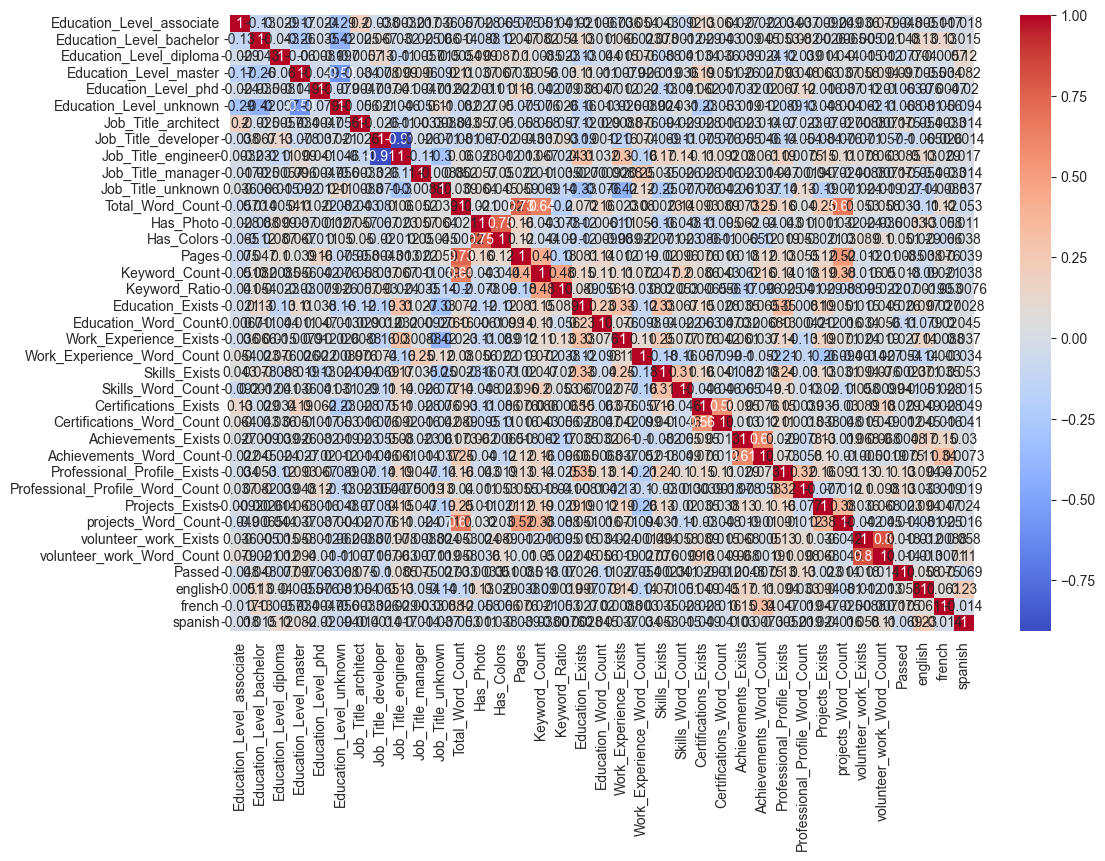

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(baseCVs.corr(), annot=True, cmap="coolwarm")
plt.show()

In [31]:
# Get correlation with "Passed" column
correlation_with_target = baseCVs.corr()["Passed"].drop("Passed")  # Remove self-correlation

# Sort features by absolute correlation value (strongest correlations first)
important_features = correlation_with_target.abs().sort_values(ascending=False)

# Display top 10 most important features
print("🔹 Top 15 Most Correlated Features with 'Passed':")
print(important_features.head(15))


🔹 Top 15 Most Correlated Features with 'Passed':
Professional_Profile_Exists        0.129823
Professional_Profile_Word_Count    0.128766
Education_Word_Count               0.106587
Job_Title_developer                0.102275
Education_Level_master             0.096815
Job_Title_engineer                 0.085244
Education_Level_diploma            0.076789
Job_Title_manager                  0.074689
french                             0.074689
Job_Title_architect                0.074689
Keyword_Ratio                      0.069710
spanish                            0.068702
Education_Level_unknown            0.068271
Education_Level_phd                0.062594
english                            0.057535
Name: Passed, dtype: float64


### Revisamos con random forest las que más contribuyen

In [32]:
from sklearn.ensemble import RandomForestClassifier

X = baseCVs.drop("Passed", axis=1)
y = baseCVs["Passed"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))


Work_Experience_Word_Count         0.100952
Keyword_Ratio                      0.100630
Total_Word_Count                   0.086287
Keyword_Count                      0.083451
Education_Word_Count               0.083287
Skills_Word_Count                  0.078849
Professional_Profile_Word_Count    0.071306
projects_Word_Count                0.068017
Pages                              0.054647
Certifications_Word_Count          0.026617
Achievements_Word_Count            0.025073
english                            0.019433
Education_Level_master             0.018441
Professional_Profile_Exists        0.015821
Has_Colors                         0.014428
Has_Photo                          0.014309
Skills_Exists                      0.012953
Education_Level_unknown            0.012906
Job_Title_engineer                 0.012744
Job_Title_developer                0.012516
Projects_Exists                    0.012501
Achievements_Exists                0.011067
Education_Level_bachelor        

In [33]:
top_features = feature_importances.nlargest(10).index
print((top_features))

Index(['Work_Experience_Word_Count', 'Keyword_Ratio', 'Total_Word_Count',
       'Keyword_Count', 'Education_Word_Count', 'Skills_Word_Count',
       'Professional_Profile_Word_Count', 'projects_Word_Count', 'Pages',
       'Certifications_Word_Count'],
      dtype='object')


### Revisamos el balanceo de la base

In [34]:
print(baseCVs["Passed"].value_counts(normalize=True))  # Show % of each class

Passed
0    0.628289
1    0.371711
Name: proportion, dtype: float64


### Identificamos outliers

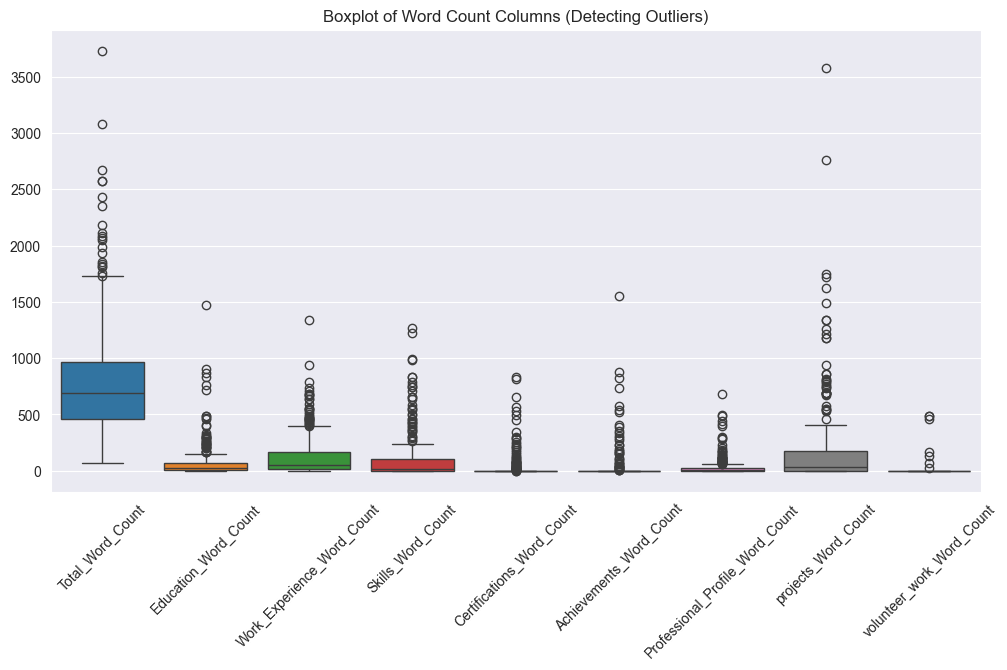

In [35]:
#Creamos una variable que nos permite separar las variables word_count, las que pueden presentar mayor cantidad de outliers
word_count_cols = [col for col in baseCVs.columns if "Word_Count" in col]  # Get all word count columns

plt.figure(figsize=(12, 6))
sns.boxplot(data=baseCVs[word_count_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Word Count Columns (Detecting Outliers)")
plt.show()

In [36]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Print outliers for each word count column
for col in word_count_cols:
    outliers = detect_outliers_iqr(baseCVs, col)
    print(f"📌 {col} has {len(outliers)} outliers.")

📌 Total_Word_Count has 20 outliers.
📌 Education_Word_Count has 37 outliers.
📌 Work_Experience_Word_Count has 32 outliers.
📌 Skills_Word_Count has 37 outliers.
📌 Certifications_Word_Count has 60 outliers.
📌 Achievements_Word_Count has 41 outliers.
📌 Professional_Profile_Word_Count has 41 outliers.
📌 projects_Word_Count has 35 outliers.
📌 volunteer_work_Word_Count has 7 outliers.


### Imputamos outliers con la técnica winsorization
Limitamos los outliers al 5%

In [37]:
from scipy.stats.mstats import winsorize

# Exclude "volunteer_work_Word_Count" from winsorization
columns_to_winsorize = [col for col in word_count_cols if col != "volunteer_work_Word_Count"]

for col in columns_to_winsorize:
    baseCVs[col] = winsorize(baseCVs[col], limits=[0, 0.10])  # 10% upper limit

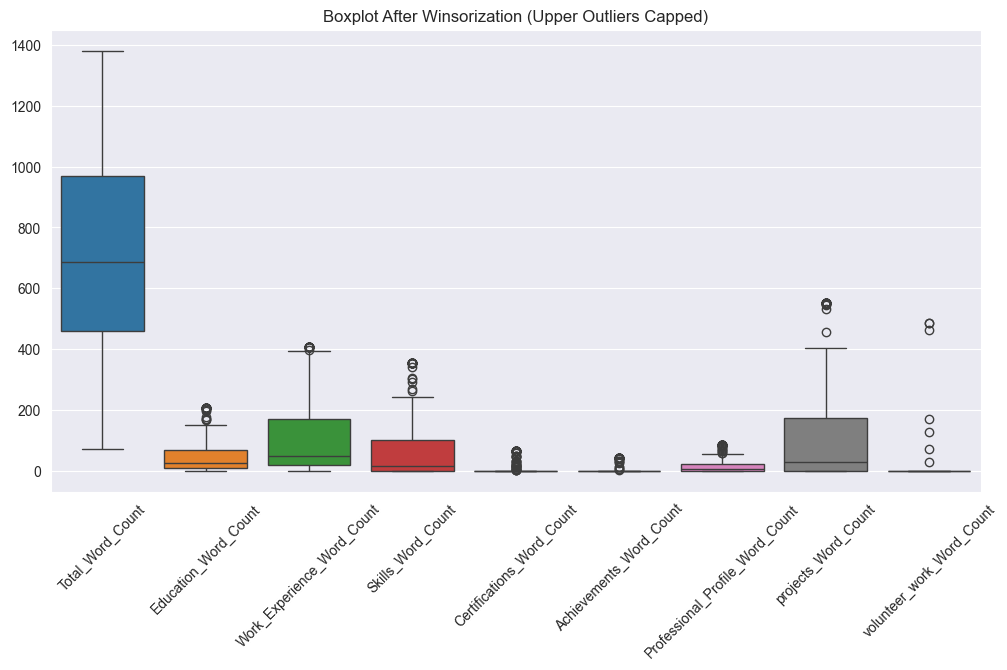

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=baseCVs[word_count_cols])
plt.xticks(rotation=45)
plt.title("Boxplot After Winsorization (Upper Outliers Capped)")
plt.show()

In [39]:
baseCVs

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,spanish
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,4,1,101,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,29,0,0,0,0,0,1,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,354,0,0,0,1,0,0
300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,10,0,0,0,0,1,0,0,0
301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,7,1,551,0,0,1,0,0,0
302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,47,1,12,0,0,0,0,0,0


In [42]:
baseCVs.to_csv("baseCVsJava.csv", index=False)